In [236]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [237]:
import cv2
import numpy as np

In [238]:
import sys
sys.path.append('../')

In [239]:
from depth_Functions import import_raw_colour_image, show_img, show_array_of_images

# Theory

In accordance with [3-D Depth Reconstruction from a Single Still Image](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf) we need to get the feature vector of a patch.

We obtain a vector of length 34. A standard and squared version of:

1. 9 texture variations:
    - Each texture variation is obtained using one of the 9 Laws' masks of the intensity
1. 2 Haze variations:
    - 1st Laws' mask applied to the red difference and blue difference
1. 6 texture gradients:
    - Edge detection at angle intervals of $30^\circ$

# Image

## BGR

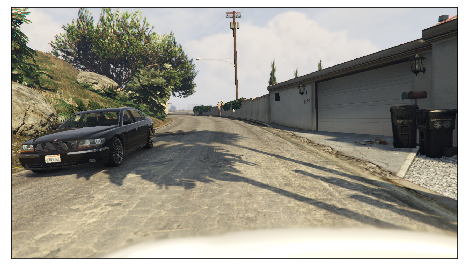

In [240]:
bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')
show_img(bgr)

## YCbCR

Convert the image from BGR to YCrCb:
1. Y: Intensity (luminance)
1. Cr: Red difference
1. Cb: Blue difference

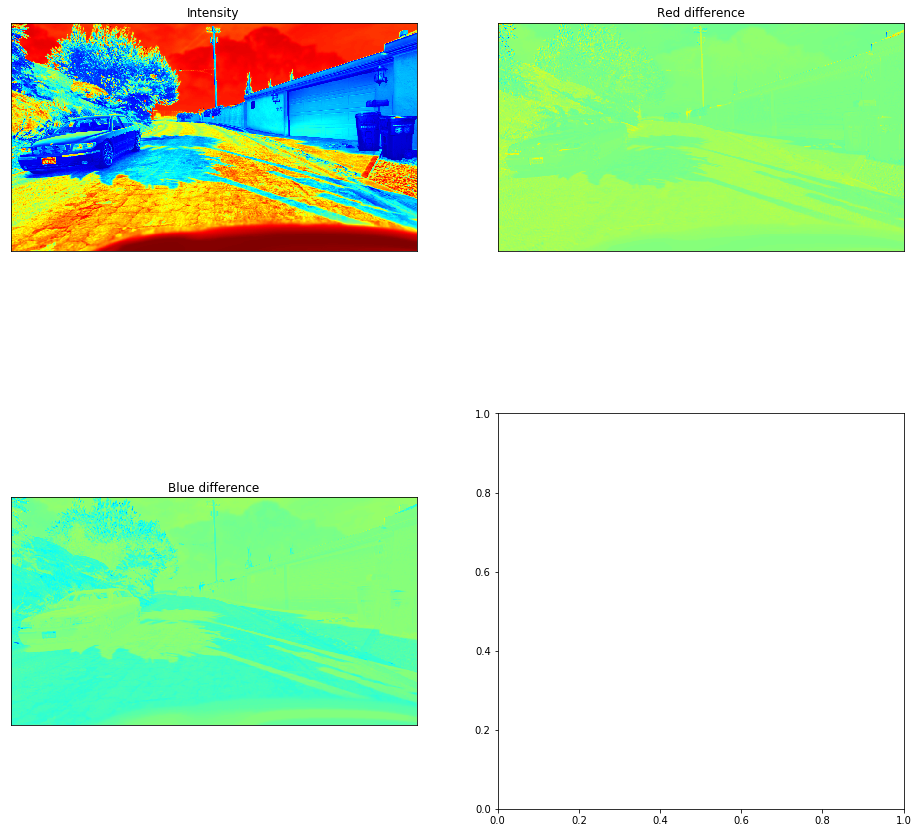

In [243]:
ycc = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb) 

show_array_of_images([ycc[:,:,i] for i in range(3)], shape=(2,2), heatmap=True,
                     titles=['Intensity', 'Red difference', 'Blue difference'])

As we'll be carrying out different implementations on each channel, we'll separate them into different arrays

In [244]:
y, cr, cb = cv2.split(ycc)

# Laws' Mask 

[Based on](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect12.pdf)

In [245]:
filters = [
                np.array([ 1,  4,  6,  4,  1]),
                np.array([-1, -2,  0,  2,  1]),
                np.array([-1,  0,  2,  0, -1]),
                np.array([ 1, -4,  6, -4,  1])
               ] 
def mask(patch, first, second=None):
    
    
    if second is None:
        return cv2.filter2D(patch, -1, filters[first].reshape(5,1)*filters[first])
    else:
        filter1 = cv2.filter2D(patch, -1, filters[first].reshape(5,1)*filters[second])
        filter2 = cv2.filter2D(patch, -1, filters[second].reshape(5,1)*filters[first])
        return (filter1 + filter2)/2

def texture_variation(patch_intensity):
    level, edge, spot, ripple = 0, 1, 2, 3
    
    masks = [
                mask(patch_intensity, level, edge),
                mask(patch_intensity, level, ripple),
                mask(patch_intensity, edge, spot),
                mask(patch_intensity, spot),
                mask(patch_intensity, ripple),
                mask(patch_intensity, level, spot),
                mask(patch_intensity, edge),
                mask(patch_intensity, edge, ripple),
                mask(patch_intensity, spot, ripple),
             ]
    
    return masks

def haze(cr, cb):
    
    return [mask(cr, 0, 1), mask(cb, 0, 1)]

In [246]:
laws = texture_variation(y) + haze(cr, cb)

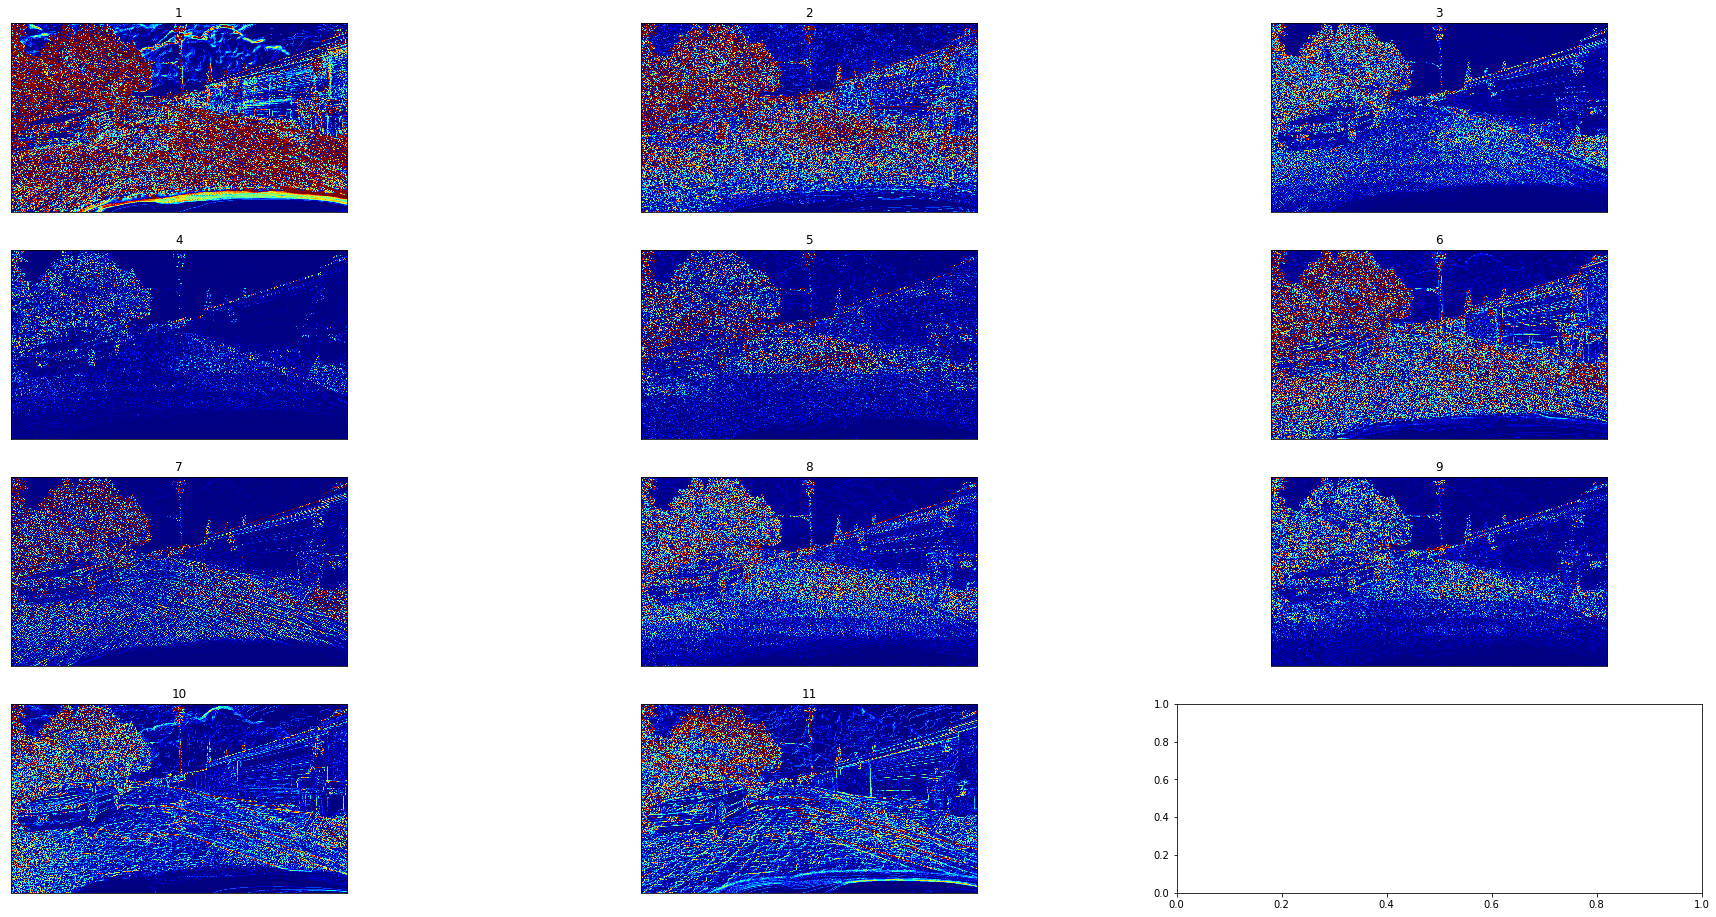

In [247]:
show_array_of_images(laws, figsize=(16,32), heatmap=True,
                     titles=[i for i in range(1,12)])

# Edge detection

The angle the edge detector registers the change in gradient is determined by the kernel.

In [248]:
import math

def create_kernels(step=90, min=0, max=180):
    kernels = []
    
    for angle in range(min,max,step):
        rad = math.radians(angle)
        cos = round(math.cos(rad),2)
        sin = round(math.sin(rad),2)
        kernels.append(np.array([
                                    [sin-cos,   2*sin, cos+sin],
                                    [-2*cos,        0,   2*cos],
                                    [-sin-cos, -2*sin, cos-sin] 
                                ]))
    
    return kernels

[OpenCV canny edge detection](https://github.com/opencv/opencv/blob/master/modules/imgproc/src/canny.cpp) is predetermined to combine vertical and horizontal edge detection with no means to input custom kernels. So use our own implementation, [based on a tutorial by towards datascience](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123).

In [249]:
from scipy import ndimage

def denoise(patch, size=5, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g_kernel =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return ndimage.filters.convolve(patch, g_kernel)

def texture_gradients(patch, *args, **kwargs):
    kernels = create_kernels(*args, **kwargs)
    gausian = denoise(patch)
    gradients = []
    
    for kernel in kernels:
        gradients.append(ndimage.filters.convolve(patch, kernel))
        
    return gradients
    
# For if we implement thresholds:
# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def get_thresholds(patch, sigma=0.33):
    v = np.median(patch)
    
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 - sigma) * v))

In [250]:
edges = texture_gradients(y, step=30)

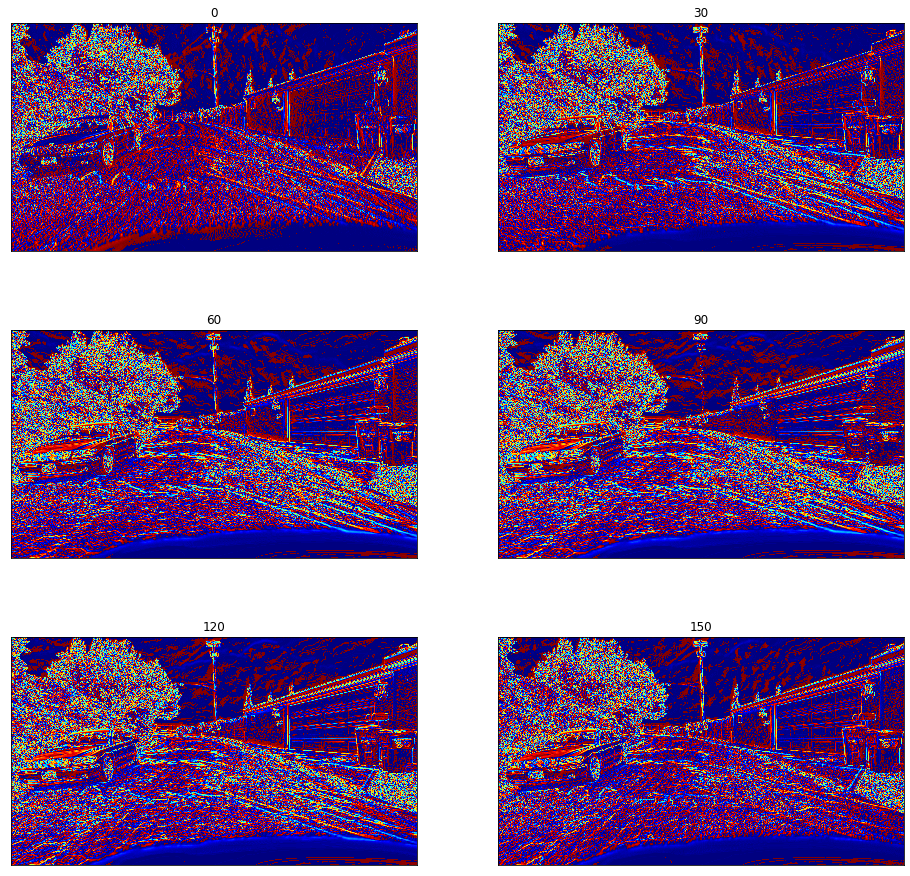

In [251]:
show_array_of_images(edges, depthmap=True,
                     titles = [i for i in range(0,180,30)])

In [252]:
def create_local_feature_vector(patch):
    vector = []
    y, cr, cb = cv2.split(cv2.cvtColor(patch, cv2.COLOR_BGR2YCrCb))
    
    vector = texture_variation(y) 
    vector += haze(cr, cb)
    vector += texture_gradients(y, step=30)
    vector += [feature**2 for feature in vector]
    return [np.sum(feature) for feature in vector]

# Separating the image into patches

In [253]:
np.zeros(len(create_local_feature_vector(bgr[0:1,0:1])))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [254]:
shape = bgr.shape
shape + (0,)

(720, 1280, 3, 0)

In [261]:
from tqdm.notebook import tqdm, trange

def process_patches(image, patchsize, function=lambda x: x):
    if isinstance(patchsize, int):
        patchsize = [patchsize,patchsize]
    
    # Adjust patchsize so we have nxm equal sized patches across image
    while image.shape[0] % patchsize[0] > 0:
        patchsize[0] -= 1
        if image.shape[1] % patchsize[1] > 0:
            patchsize[1] -= 1
    
    while image.shape[1] % patchsize[1] > 0:
            patchsize[1] += 1
    
    nxm = [int(i_dim / p_dim) for i_dim, p_dim in zip(image.shape, patchsize)]
    
    # Currently we get the shape by quickly running the function on the whole image, should be improved
    patches = np.zeros((*nxm,*np.array(function(image)).shape))
    
    for y in trange(nxm[0], leave=False):
        for x in range(nxm[1]):
            patches[y, x] = np.array(function(image[y*patchsize[0]:(y+1)*patchsize[0], x*patchsize[1]:(x+1)*patchsize[1]]))
    
    return patches

In [267]:
patch_6x8 = process_patches(bgr, 6, function=create_local_feature_vector)

In [268]:
patch_6x8.shape

(120, 160, 34)

In [ ]:
show_img(patch_6x6[:,:,0])

In [ ]:
def image_from_patches(patches, dimensions):
    image = np.zeros((*dimensions[:2],*patches.shape[2:]))
    
    patchsize = (int(image.shape[0] / patches.shape[0]), int(image.shape[1] / patches.shape[1]))
    
    for y in trange(patches.shape[0], leave=False):
        for x in range(patches.shape[1]):
            image[y*patchsize[0]:(y+1)*patchsize[0], x*patchsize[1]:(x+1)*patchsize[1]] = patches[y, x]
    
    return image

In [ ]:
image_120x120 = image_from_patches(patch_120x120[:,:,0], ycc.shape)

In [ ]:
image_120x120.shape

In [ ]:
show_img(image_120x120)